# Population Segmentation Notebook

This notebook develops unsupervised and interpretable segmentation models to group individuals into **distinct population segments** based on demographic and employment-related attributes. These segments are intended to support Walmart’s marketing strategy by identifying meaningful consumer groups and highlighting how they differ.  


In [2]:
# Setup and load
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


In [3]:
# Paths
COLUMNS_PATH = "../data/census-bureau.columns"
DATA_PATH    = "../data/census-bureau.data"
MODELS_DIR   = "../models"
os.makedirs(MODELS_DIR, exist_ok=True)

In [4]:
# Load data (header + data)
with open(COLUMNS_PATH, "r") as f:
    COLS = [line.strip() for line in f if line.strip()]
df = pd.read_csv(DATA_PATH, header=None, names=COLS)

TARGET_COL = "label"
WEIGHT_COL = "weight"
RANDOM_STATE = 42


---
## Data Cleaning

We apply straightforward preprocessing to ensure consistent datatypes.  
- Numeric columns are coerced into numeric types.  
- CPS-coded binary flags are mapped to `"Yes"`, `"No"`, or `"NIU"`.  
- Certain code columns with `0` or missing values are standardized as `"NIU"`.  
- The survey year is treated as a categorical variable.


In [6]:
def clean_data(df_):
    df = df_.copy()

    # Convert selected columns to numeric
    for c in [
        "age",
        "wage per hour",
        "capital gains",
        "capital losses",
        "dividends from stocks",
        "weeks worked in year",
        "num persons worked for employer",
        WEIGHT_COL,
    ]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Map CPS codes: 0=NIU, 1=Yes, 2=No
    code_map_yn = {0: "NIU", 1: "Yes", 2: "No"}
    for c in ["own business or self employed", "veterans benefits"]:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce").astype("Int64")
            df[c] = s.map(code_map_yn).astype("string").fillna("NIU")

    # Code columns where 0 means NIU
    for c in ["detailed industry recode", "detailed occupation recode"]:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce").astype("Int64")
            df[c] = s.astype("string")
            df.loc[s.eq(0) | s.isna(), c] = "NIU"

    # Map survey year to strings
    if "year" in df.columns:
        s = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
        df["year"] = s.map({94: "1994", 95: "1995"}).astype("string")

    return df


In [7]:
y = df[TARGET_COL].map({"- 50000.": 0, "50000+.": 1}).astype(int)
w = pd.to_numeric(df[WEIGHT_COL], errors="coerce").fillna(0.0)
X = df.drop(columns=[TARGET_COL])

X_clean = clean_data(X)
X_fe    = X_clean

feature_cols = [c for c in X_fe.columns if c != WEIGHT_COL]
print("Segmentation base shape:", X_fe[feature_cols].shape)

Segmentation base shape: (199523, 40)


---
## Preprocessing: Imputation, Encoding, and Scaling

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# numeric + categorical columns
num_cols = [
    "age",
    "weeks worked in year",
    "wage per hour",
    "capital gains", "capital losses", "dividends from stocks",
    "num persons worked for employer",
]
num_cols = [c for c in num_cols if c in X_fe.columns]

cat_cols = [
    "class of worker",
    "detailed industry recode",
    "detailed occupation recode",
    "marital stat",
    "major industry code",
    "major occupation code",
    "race",
    "hispanic origin",
    "sex",
    "member of a labor union",
    "reason for unemployment",
    "full or part time employment stat",
    "tax filer stat",
    "region of previous residence",
    "state of previous residence",
    "detailed household and family stat",
    "detailed household summary in household",
    "migration code-change in msa",
    "migration code-change in reg",
    "migration code-move within reg",
    "live in this house 1 year ago",
    "migration prev res in sunbelt",
    "family members under 18",
    "country of birth father",
    "country of birth mother",
    "country of birth self",
    "citizenship",
    "fill inc questionnaire for veteran's admin",
    "veterans benefits",
]
cat_cols = [c for c in cat_cols if c in X_fe.columns]

# split numeric: skewed vs regular
skewed_num = [c for c in ["capital gains", "capital losses", "dividends from stocks"] if c in num_cols]
regular_num = [c for c in num_cols if c not in skewed_num]

# OneHotEncoder compatibility across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num_skewed", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("clip0", FunctionTransformer(lambda x: np.clip(x, 0, None), feature_names_out="one-to-one")),
            ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
            ("scale", RobustScaler())
        ]), skewed_num),
        ("num_regular", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), regular_num),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), cat_cols),
    ],
    remainder="drop"
)

# Fit + transform
X_small = pre.fit_transform(X_fe[num_cols + cat_cols])

In [10]:
X_small.shape

(199523, 483)

---
## Model training and evaluation

### kmeans

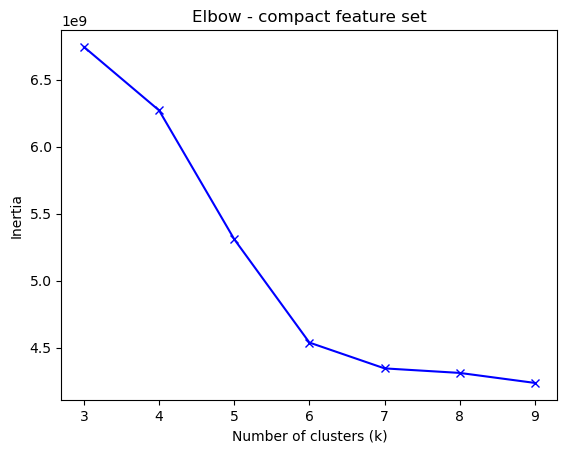

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans


Ks = list(range(3, 10))
inertias = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    km.fit(X_small, sample_weight=w)
    inertias.append(km.inertia_)

plt.plot(Ks, inertias, "bx-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow - compact feature set")
plt.show()

inertias = np.array(inertias, dtype=float)
dd = np.diff(inertias, 2)
k_opt = Ks[1:-1][int(np.argmin(dd))]


In [14]:
k_opt=6

In [15]:

km = KMeans(n_clusters=k_opt, random_state=RANDOM_STATE, n_init=10)
km.fit(X_small, sample_weight=w)
labels = km.labels_
X_fe[f"segment_kmeans_{k_opt}"] = labels

rows = []
for seg in np.unique(labels):
    mask = (labels == seg)
    w_c = w[mask].to_numpy()
    sw = float(w_c.sum()) if w_c.sum() > 0 else 1.0
    share = float(w_c.sum()) / float(w.sum()) if w.sum() > 0 else 0.0

    y_c = y[mask].to_numpy()
    pos_rate = float((w_c * y_c).sum() / sw)

    row = {
        "cluster": int(seg),
        "weighted_share": share,
        "weighted_pos_rate": pos_rate,
    }

    # Weighted means for numeric columns that exist
    for nc in ("age", "weeks worked in year", "wage per hour", "num persons worked for employer"):
        if nc in X_fe.columns:
            vals = pd.to_numeric(X_fe.loc[mask, nc], errors="coerce").fillna(0).to_numpy()
            row[f"mean_{nc}"] = float((w_c * vals).sum() / sw)

    rows.append(row)

summary_km = pd.DataFrame(rows).sort_values("weighted_share", ascending=False)
print(f"\nKMeans segments (k={k_opt}) - weighted")
print(summary_km.to_string(index=False))


KMeans segments (k=6) - weighted
 cluster  weighted_share  weighted_pos_rate  mean_age  mean_weeks worked in year  mean_wage per hour  mean_num persons worked for employer
       1        0.262660           0.000000  8.132863                   0.225029            0.142715                              0.055082
       2        0.217050           0.066982 36.884792                  43.726788          114.682966                              3.624814
       0        0.216387           0.077016 37.110557                  44.354857          111.414357                              3.761524
       3        0.184931           0.006739 56.028342                   1.440061            0.000000                              0.239743
       4        0.081851           0.235871 50.647314                  33.045413           65.604277                              2.861096
       5        0.037120           0.331204 48.342508                  39.427064           79.691527                              3.

In [16]:
# Bucket numeric fields for categorical-style profiling
if "age" in X_fe.columns:
    age_vals = pd.to_numeric(X_fe["age"], errors="coerce")
    X_fe["age_band"] = pd.cut(
        age_vals,
        bins=[-np.inf, 17, 24, 34, 44, 54, 64, np.inf],
        labels=["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
    )

if "weeks worked in year" in X_fe.columns:
    weeks_vals = pd.to_numeric(X_fe["weeks worked in year"], errors="coerce")
    X_fe["weeks_band"] = pd.cut(
        weeks_vals,
        bins=[-np.inf, 0, 13, 26, 39, 47, np.inf],
        labels=["0", "1-13", "14-26", "27-39", "40-47", "48-52+"]
    )

# Major categorical columns for weighted top-category summaries
major_cats = [
    "age_band",
    "education", "class of worker", "marital stat",
    "full or part time employment stat", "sex",
    "major industry code", "major occupation code",
    "detailed industry recode", "detailed occupation recode",
    "race", "hispanic origin", "member of a labor union",
    "tax filer stat", "citizenship",
    "enroll in edu inst last wk",
    "reason for unemployment",
    "detailed household and family stat",
    "detailed household summary in household",
    "family members under 18",
    "region of previous residence", "state of previous residence",
    "migration code-change in msa", "migration code-change in reg",
    "migration code-move within reg", "live in this house 1 year ago",
    "migration prev res in sunbelt",
    "country of birth father", "country of birth mother", "country of birth self",
    "own business or self employed", "veterans benefits",
    "fill inc questionnaire for veteran's admin",
    "year",
    "weeks_band",
]
major_cats = [c for c in major_cats if c in X_fe.columns]

# Weighted top categories by cluster (top 3 per cluster)
for cat in major_cats:
    print(f"\nTop categories by cluster - {cat} (k={k_opt})")
    for seg in np.unique(labels):
        mask = (labels == seg)
        vc = X_fe.loc[mask, cat].astype("string").fillna("NA").to_numpy()
        w_c = w[mask].to_numpy()
        wf = (
            pd.DataFrame({"v": vc, "w": w_c})
            .groupby("v", dropna=False)["w"]
            .sum()
            .sort_values(ascending=False)
        )
        denom = w_c.sum() if w_c.sum() > 0 else 1.0
        top3 = [f"{kcat} ({val/denom:.2%})" for kcat, val in wf.head(3).items()]
        print(f"  cluster {int(seg)}: {', '.join(top3)}")



Top categories by cluster - age_band (k=6)
  cluster 0: 25-34 (27.60%), 35-44 (26.09%), 45-54 (17.05%)
  cluster 1: <18 (98.58%), 18-24 (1.41%), 25-34 (0.01%)
  cluster 2: 25-34 (28.21%), 35-44 (25.95%), 18-24 (17.00%)
  cluster 3: 65+ (43.94%), 55-64 (14.37%), 25-34 (11.83%)
  cluster 4: 65+ (22.56%), 35-44 (22.13%), 45-54 (21.72%)
  cluster 5: 35-44 (24.49%), 65+ (21.39%), 45-54 (20.90%)

Top categories by cluster - education (k=6)
  cluster 0: High school graduate (34.43%), Some college but no degree (21.79%), Bachelors degree(BA AB BS) (14.22%)
  cluster 1: Children (86.72%), 9th grade (4.03%), 10th grade (3.34%)
  cluster 2: High school graduate (35.28%), Some college but no degree (22.01%), Bachelors degree(BA AB BS) (13.90%)
  cluster 3: High school graduate (34.72%), Some college but no degree (14.62%), 7th and 8th grade (10.56%)
  cluster 4: Bachelors degree(BA AB BS) (27.37%), High school graduate (24.76%), Some college but no degree (18.33%)
  cluster 5: High school graduat

In [17]:
from matplotlib.ticker import PercentFormatter

def _cluster_order(labels):
    clusters = np.unique(labels)
    try:
        return sorted(int(c) for c in clusters)
    except Exception:
        return sorted(clusters, key=lambda x: str(x))

def plot_cluster_sizes(labels, w, title="Cluster weighted share"):
    order = _cluster_order(labels)
    shares = []
    for c in order:
        m = (labels == c)
        shares.append(w[m].sum() / w.sum() if w.sum() > 0 else 0.0)

    plt.figure(figsize=(7,4))
    bars = plt.bar([str(c) for c in order], shares, color="#4C72B0")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    for b, s in zip(bars, shares):
        plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{s*100:.1f}%", 
                 ha="center", va="bottom", fontsize=9)
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel("Weighted share")
    plt.tight_layout()
    plt.show()

def weighted_crosstab(cat, top_n=6):
    order = _cluster_order(labels)
    vc_all = (
        pd.DataFrame({"v": X_fe[cat].astype("string").fillna("NA"), "w": w})
        .groupby("v")["w"].sum().sort_values(ascending=False)
    )
    cats = vc_all.head(top_n).index.tolist()

    rows = []
    for c in order:
        m = (labels == c)
        w_c = w[m]
        denom = w_c.sum() if w_c.sum() > 0 else 1.0
        vc = (
            pd.DataFrame({"v": X_fe.loc[m, cat].astype("string").fillna("NA"), "w": w_c})
            .groupby("v")["w"].sum()
            .reindex(cats, fill_value=0.0)
        )
        rows.append((c, (vc / denom).to_numpy()))
    data = np.vstack([r[1] for r in rows])
    return pd.DataFrame(data, index=[r[0] for r in rows], columns=cats)

def plot_heatmap(df, title):
    plt.figure(figsize=(max(7,1.3*len(df.columns)), 0.6*len(df.index)+2))
    im = plt.imshow(df.values, cmap="Blues", aspect="auto", vmin=0, vmax=1)

    plt.colorbar(im, fraction=0.046, pad=0.04, label="Share")
    plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45, ha="right")
    plt.yticks(np.arange(df.shape[0]), [str(i) for i in df.index])
    plt.title(title)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            val = df.values[i, j]
            color = "white" if val > 0.4 else "black"
            plt.text(j, i, f"{val*100:.0f}%", ha="center", va="center", fontsize=9, color=color)

    plt.grid(False)
    plt.tight_layout()
    plt.show()

def plot_numeric_means(numeric_cols):
    order = _cluster_order(labels)
    for nc in numeric_cols:
        if nc not in X_fe.columns:
            continue
        means = []
        for c in order:
            m = (labels == c)
            w_c = w[m]
            denom = w_c.sum() if w_c.sum() > 0 else 1.0
            vals = pd.to_numeric(X_fe.loc[m, nc], errors="coerce").fillna(0).to_numpy()
            means.append((w_c * vals).sum() / denom)

        plt.figure(figsize=(7,4))
        bars = plt.bar([str(c) for c in order], means, color="#4C72B0")
        for b, v in zip(bars, means):
            plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.2f}",
                     ha="center", va="bottom", fontsize=9)
        plt.title(f"{nc} by cluster (weighted mean)")
        plt.xlabel("Cluster")
        plt.ylabel(nc)
        plt.tight_layout()
        plt.show()


---
### Visualizations

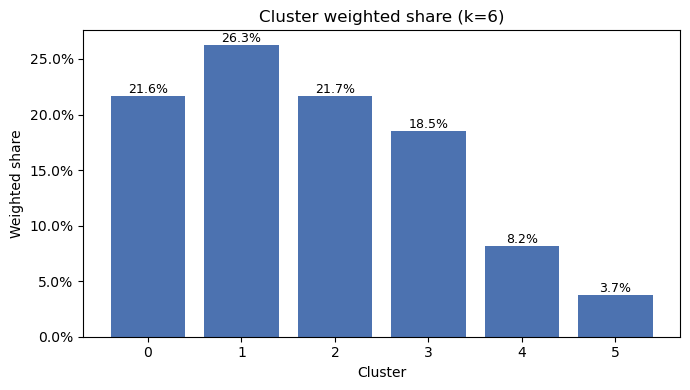

In [19]:
# Cluster size bars
plot_cluster_sizes(labels, w, title=f"Cluster weighted share (k={k_opt})")


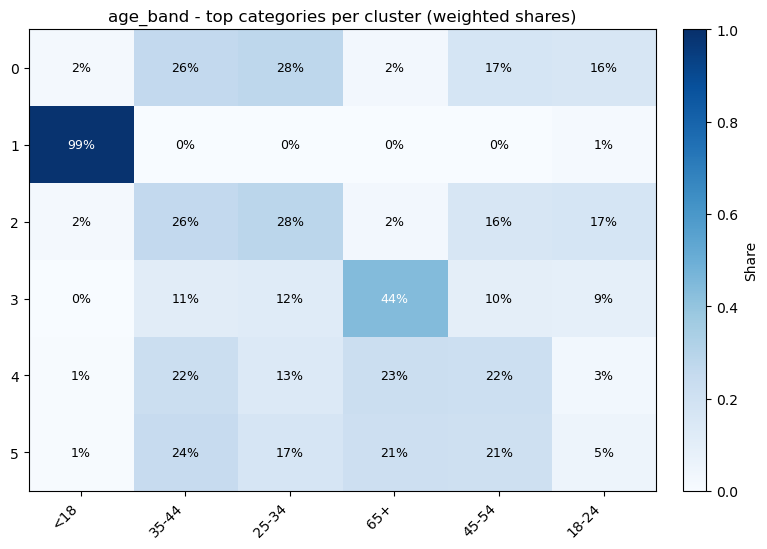

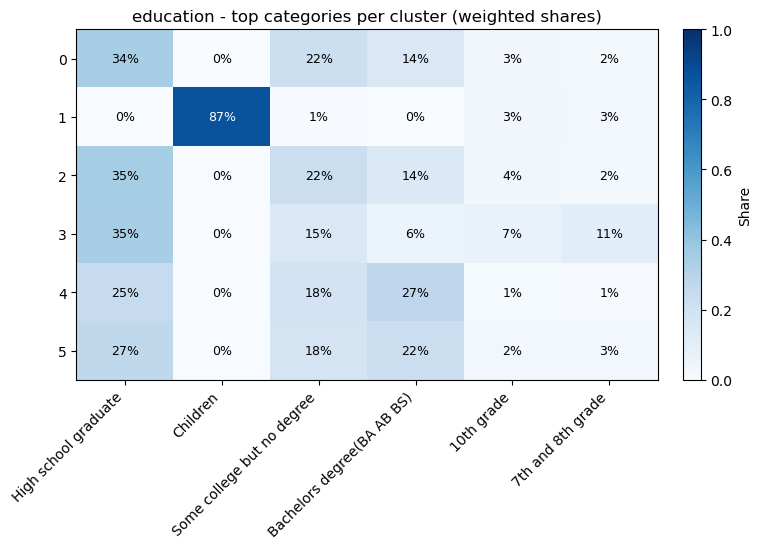

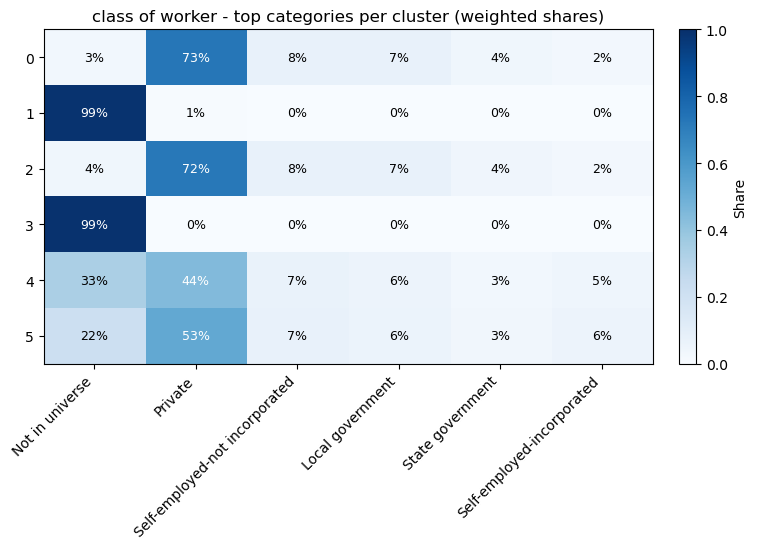

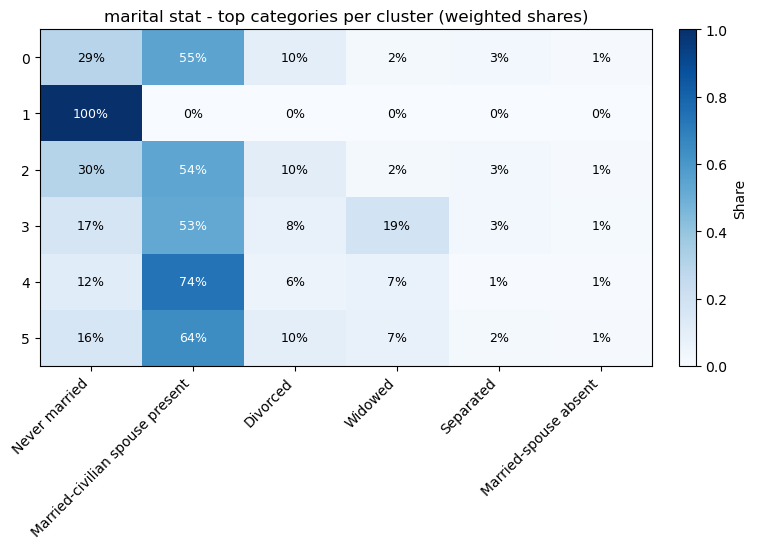

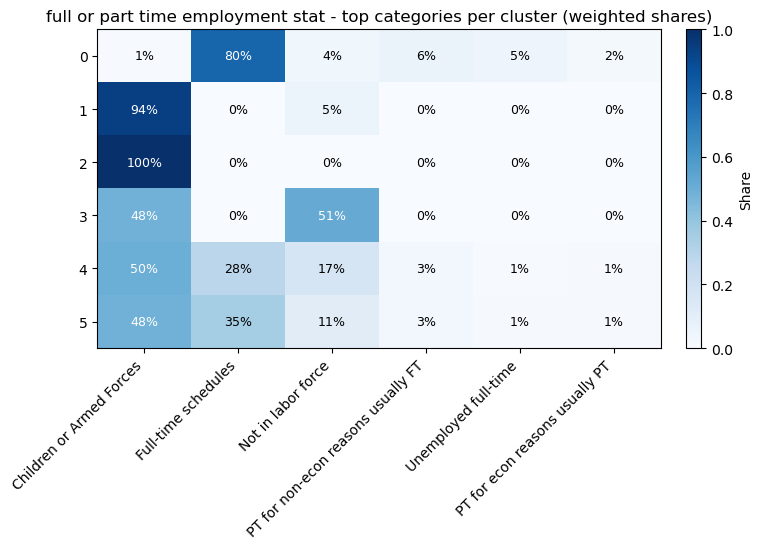

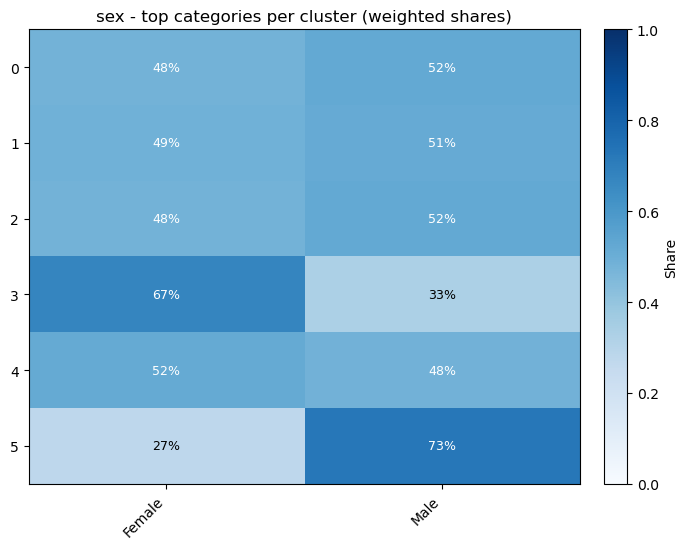

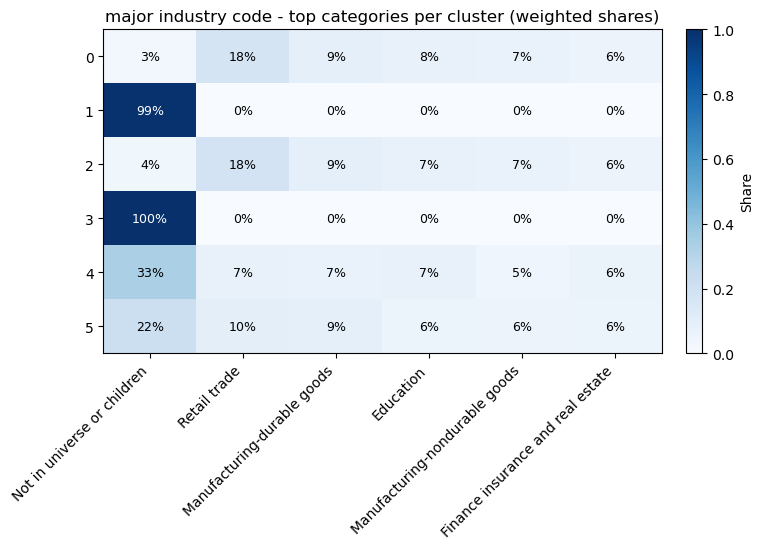

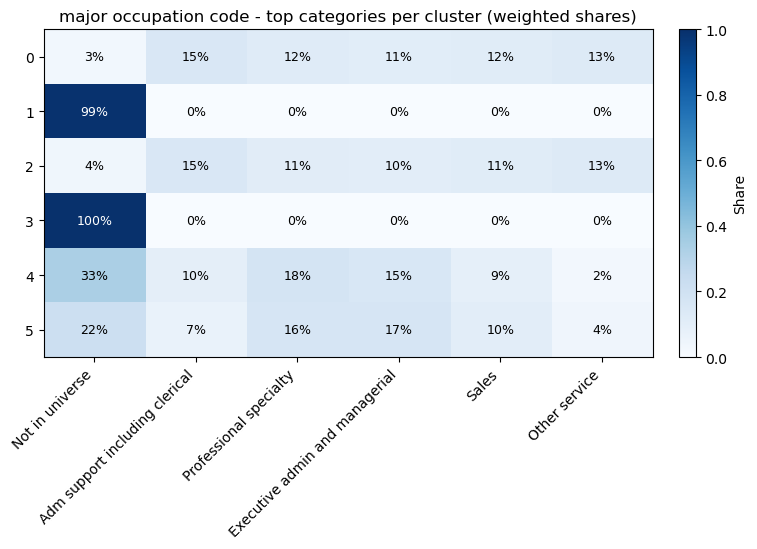

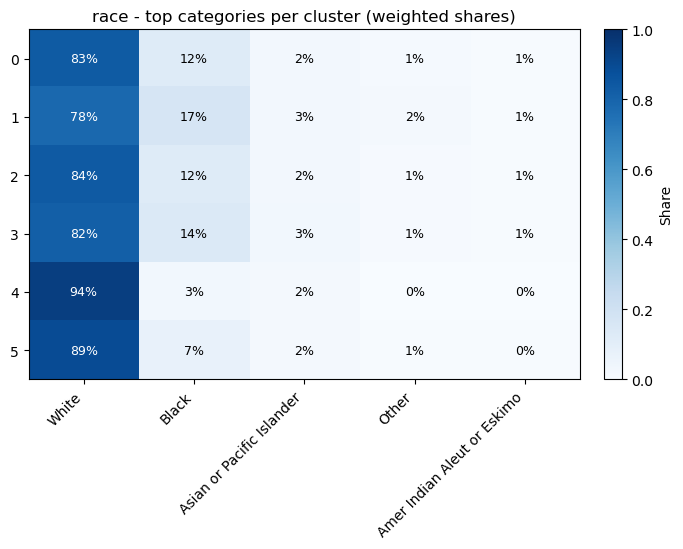

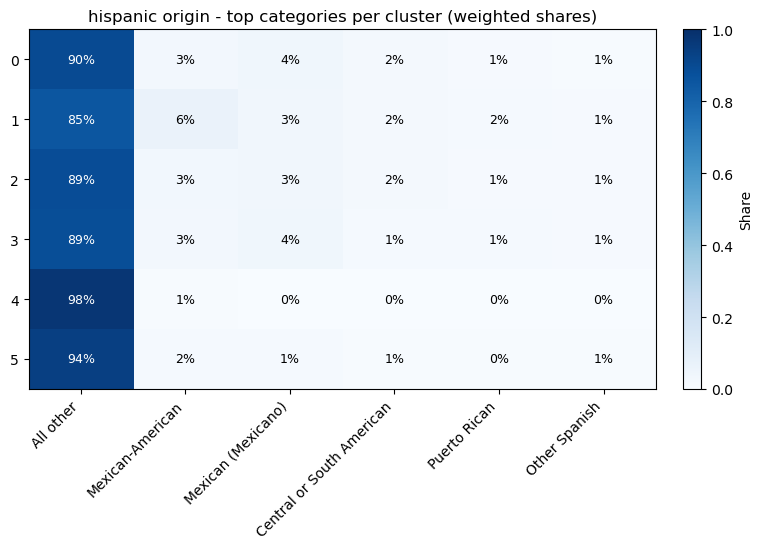

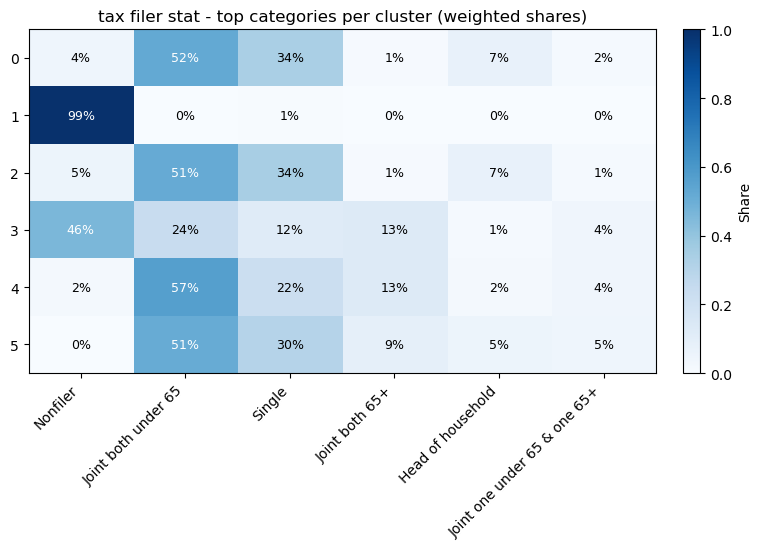

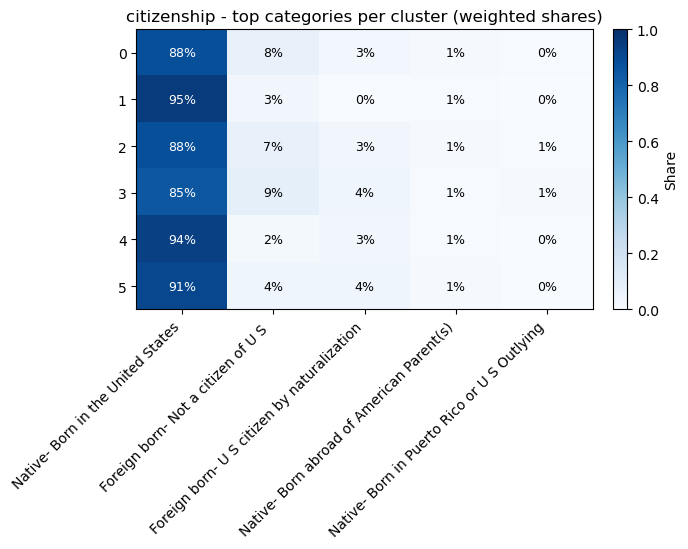

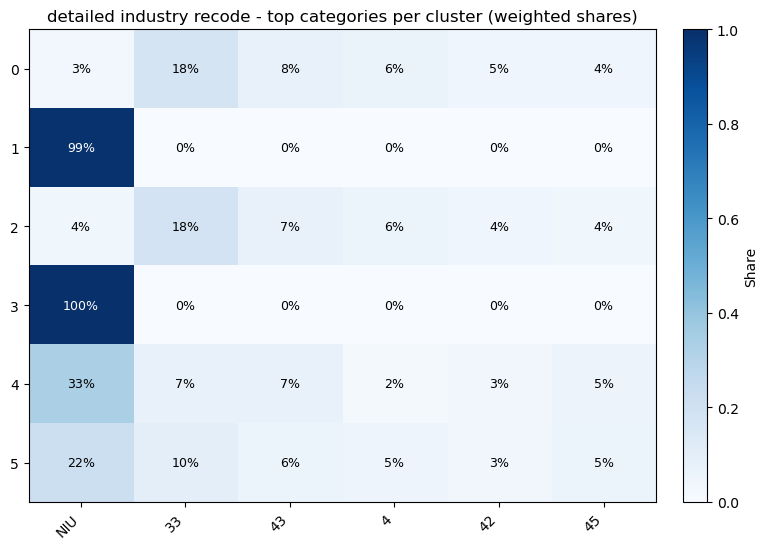

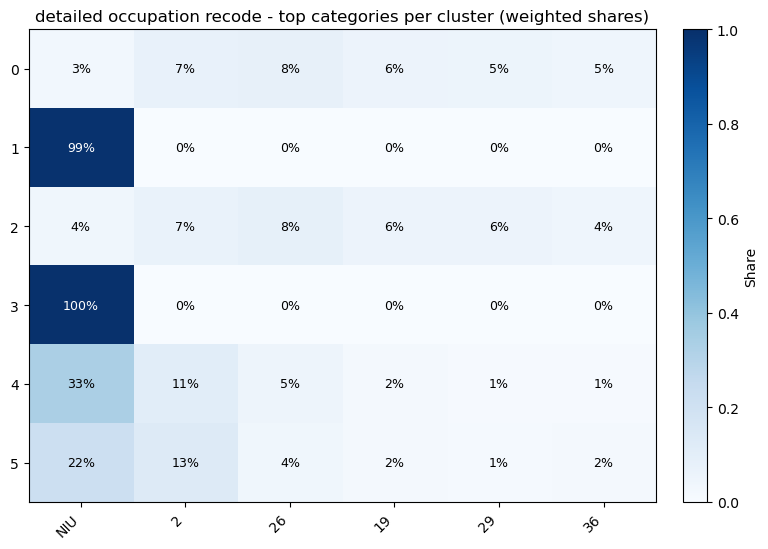

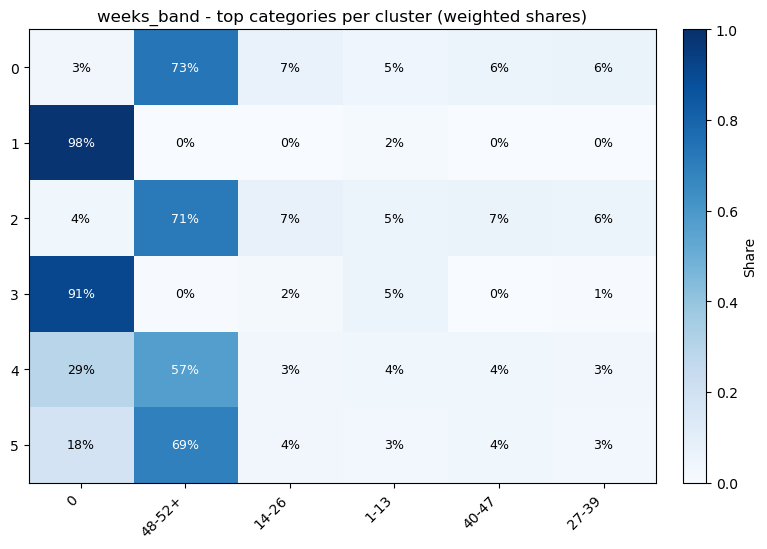

In [20]:
# Heatmaps for key categoricals
cat_vars_to_plot = [
    "age_band",
    "education", "class of worker", "marital stat",
    "full or part time employment stat", "sex",
    "major industry code", "major occupation code",
    "race", "hispanic origin",
    "tax filer stat", "citizenship",
    "detailed industry recode", "detailed occupation recode",
    "weeks_band",
]
cat_vars_to_plot = [c for c in cat_vars_to_plot if c in X_fe.columns]

for cat in cat_vars_to_plot:
    df_hm = weighted_crosstab(cat, top_n=6)
    plot_heatmap(df_hm, title=f"{cat} - top categories per cluster (weighted shares)")


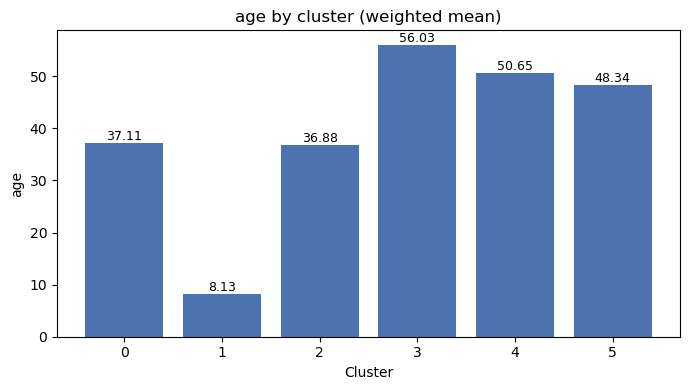

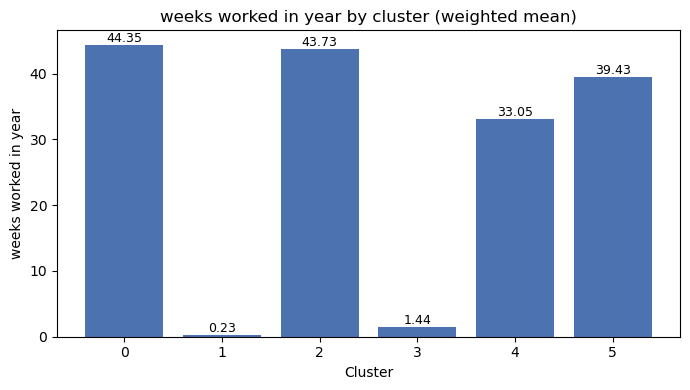

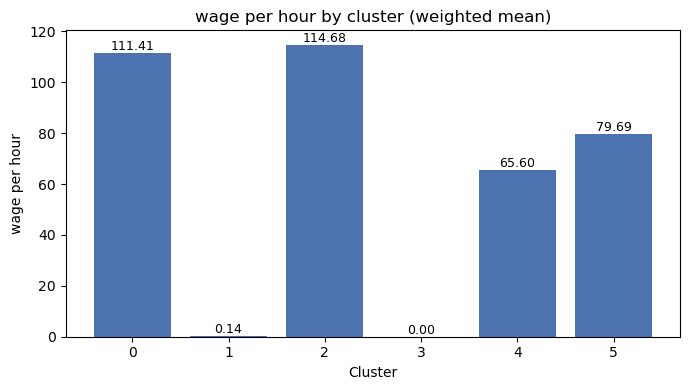

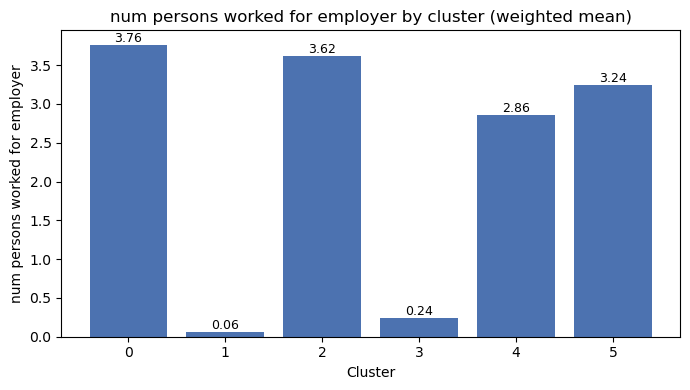

In [21]:
# Numeric means by cluster
numeric_cols_to_plot = [
    "age", "weeks worked in year", "wage per hour", "num persons worked for employer"
]
numeric_cols_to_plot = [c for c in numeric_cols_to_plot if c in X_fe.columns]
plot_numeric_means(numeric_cols_to_plot)